In [1]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F  # get avtivation functions
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
         [transforms.ToTensor(),       #將圖片轉換為Tensor，歸一化製[0,1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #把0-1變換到(-1,1)
train = torchvision.datasets.ImageFolder(root='./CIFAR-10/train/', transform=transform)
print(len(train))

2000


In [3]:
transform = transforms.Compose(
         [transforms.ToTensor(),       #將圖片轉換為Tensor，歸一化製[0,1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #把0-1變換到(-1,1)

train = torchvision.datasets.ImageFolder(root='./CIFAR-10/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=24, shuffle=True, num_workers=2)

test = transform = transforms.Compose(
         [transforms.ToTensor(),       #將圖片轉換為Tensor，歸一化製[0,1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #把0-1變換到(-1,1)

train = torchvision.datasets.ImageFolder(root='./CIFAR-10/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=24, shuffle=True, num_workers=2)

test = torchvision.datasets.ImageFolder(root='./CIFAR-10/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=len(test), shuffle=True, num_workers=2)  
print(train.class_to_idx)
print(train[0][0].size())

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'dear': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
torch.Size([3, 32, 32])


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class_names = train.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']


Text(0.5, 1.0, "['dog', 'automobile', 'airplane', 'horse', 'airplane', 'frog', 'automobile', 'ship', 'dog', 'frog', 'dog', 'frog', 'dear', 'frog', 'ship', 'dear', 'ship', 'bird', 'ship', 'bird', 'automobile', 'dear', 'bird', 'ship']")

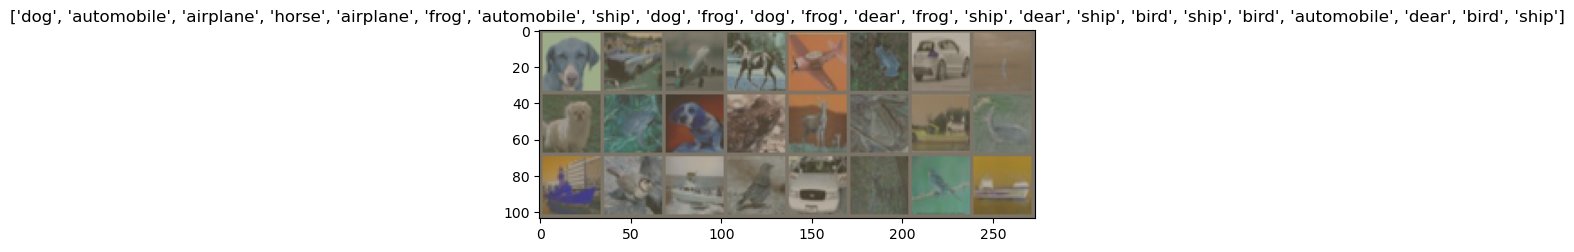

In [6]:
def tensor2img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

inputs, classes = next(iter(train_loader))
# 將多張圖片拼成一張 grid 圖
out = torchvision.utils.make_grid(inputs)
# 顯示圖片
img = tensor2img(out)
plt.imshow(img)
plt.title([class_names[x] for x in classes])

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(ResidualBlock)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
# from resnet import ResNet18
import os

# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数设置
EPOCH = 135   #遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 128      #批处理尺寸(batch_size)
LR = 0.01        #学习率

# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 模型定义-ResNet
net = ResNet18().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

if __name__ == "__main__":
    if not os.path.exists(args.outf):
        os.makedirs(args.outf)
    
    # best_acc = 85  #2 初始化best test accuracy
    # print("Start Training, Resnet-18!")  # 定义遍历数据集的次数
    with open("acc.txt", "w") as f:
        with open("log.txt", "w")as f2:
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                net.train()
                sum_loss = 0.0
                correct = 0.0
                total = 0.0
                for i, data in enumerate(train_loader, 0):
                    # 准备数据
                    length = len(train_loader)
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    # forward + backward
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    # 每训练1个batch打印一次loss和准确率
                    sum_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += predicted.eq(labels.data).cpu().sum()
                    print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                          % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
                    f2.write('%03d  %05d |Loss: %.03f | Acc: %.3f%% '
                          % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
                    f2.write('\n')
                    f2.flush()

                # 每训练完一个epoch测试一下准确率
                print("Waiting Test!")
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for data in test_loader:
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        # 取得分最高的那个类 (outputs.data的索引号)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum()
                    print('测试分类准确率为：%.3f%%' % (100 * correct / total))
                    acc = 100. * correct / total
                    # 将每次测试结果实时写入acc.txt文件中
                    print('Saving model......')
                    torch.save(net.state_dict(), '%s/net_%03d.pth' % (args.outf, epoch + 1))
                    f.write("EPOCH=%03d,Accuracy= %.3f%%" % (epoch + 1, acc))
                    f.write('\n')
                    f.flush()
                    # 记录最佳测试分类准确率并写入best_acc.txt文件中
                    if acc > best_acc:
                        f3 = open("best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc))
                        f3.close()
                        best_acc = acc
            print("Training Finished, TotalEPOCH=%d" % EPOCH)


usage: ipykernel_launcher.py [-h] [--outf OUTF]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"fd1b8105-5efb-4d70-9f8c-92428426469e" --shell=9002 --transport="tcp" --iopub=9004 --f=c:\Users\angus\AppData\Roaming\jupyter\runtime\kernel-v2-19872AS33jZu2OBqc.json


SystemExit: 2

c:\Users\angus\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
